# This code based on these codes.
https://www.kaggle.com/francksylla/titanic/titanic-machine-learning-from-disaster/code


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_input = pd.read_csv("../input/train.csv", dtype={"Age": np.float64})
test_input = pd.read_csv("../input/test.csv", dtype={"Age": np.float64})

df = pd.concat([train_input, test_input])
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


[[<matplotlib.axes._subplots.AxesSubplot object at 0x05309450>


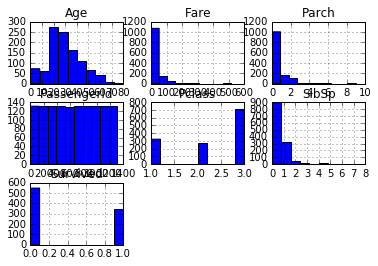

In [3]:
print(df.hist())

In [4]:
categorical_columns = ['Sex', 'Embarked']
numerical_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
text_columns = ['Name', 'Ticket']

def category_to_numeric(df, column_name):
    for category in df[column_name].unique():
        category_column = column_name + '_' + str(category)
        if category_column in df.columns:
            df = df.drop(category_column, axis=1)
        if category_column not in numerical_columns:
            numerical_columns.append(category_column)
    df= pd.concat([df,pd.get_dummies(df[column_name], prefix=column_name)],axis=1)
    return df

[[<matplotlib.axes._subplots.AxesSubplot object at 0x09F6EDB0>


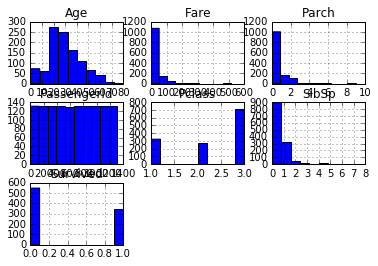

In [5]:
print(df.hist())

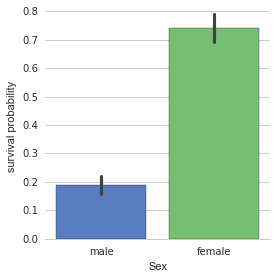

In [6]:
# Sex
import seaborn as sns
sns.set(style="whitegrid")

g = sns.factorplot(x="Sex", y="Survived", data=df, size=4, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

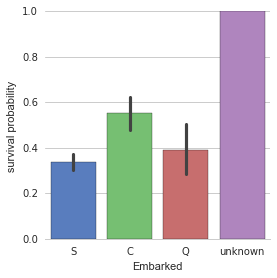

In [7]:
# Embarked
df['Embarked'] = df['Embarked'].fillna('unknown')
g = sns.factorplot(x="Embarked", y="Survived", data=df, size=4, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

if 'Embarked' not in categorical_columns:
    categorical_columns.append('Embarked')

In [8]:
# title
import re
df['Name_title'] = df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1))
print(df['Name_title'].unique())
if 'Name_title' not in categorical_columns:
    categorical_columns.append('Name_title')

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


[[<matplotlib.axes._subplots.AxesSubplot object at 0x0AC2D910>


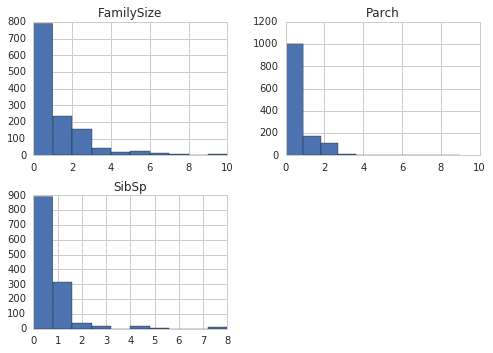

In [9]:
# FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch']
if 'FamilySize' not in numerical_columns:
    numerical_columns.append('FamilySize')
print(df[['SibSp', 'Parch', 'FamilySize']].hist())

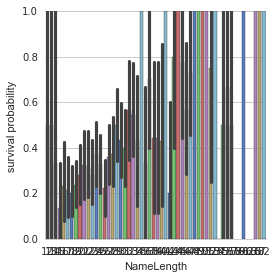

In [10]:
# Name Length?
df['NameLength'] = df["Name"].apply(lambda x: len(x))
if 'NameLength' not in numerical_columns:
    numerical_columns.append('NameLength')
g = sns.factorplot(x="NameLength", y="Survived", data=df, size=4, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

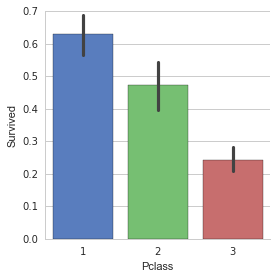

In [11]:
g = sns.factorplot(x="Pclass", y="Survived", data=df, size=4, kind="bar", palette="muted")

count    1309.000000
mean       33.295479
std        51.738879
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64
Axes(0.125,0.125;0.775x0.775)


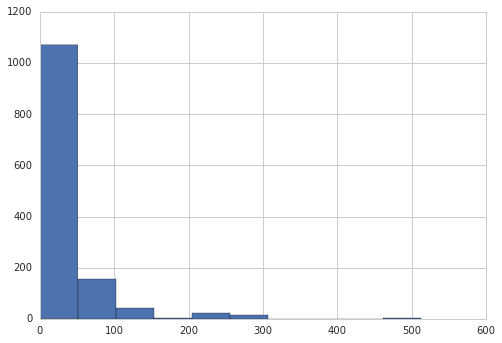

In [12]:
# Fare
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
print(df['Fare'].describe())
print(df['Fare'].hist())

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49' 'F4'
 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77' 'E67'
 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106' 'C65'
 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91' 'E40'
 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34' 'C104'
 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79' 'E25'
 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68' 'A10'
 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58' 'C126'
 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90' 'C45'
 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6' 'B82 B84'
 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50' 'B42' 'C148'
 'B45' 'B36' 'A21' 'D34' 'A9' 'C31' 'B61' 'C5

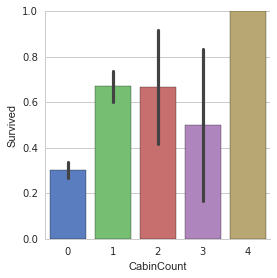

In [13]:
# cabin
print(df['Cabin'].unique())

# https://www.kaggle.com/c/titanic/prospector#1326
def get_cabin_location(cabin):
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('\d+', cabin)
    if cabin_search_result:
        type_code = np.int64(cabin_search_result.group(0))
        if type_code % 2 == 0:
            return 'port'
        else:
            return 'starboard'
    return 'unknown'

def get_cabin_deck(cabin):
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('[A-z]+', cabin)
    if cabin_search_result:
        return cabin_search_result.group(0)
    return 'unknown'

def get_cabin_count(cabin):
    cabin_search_result = re.findall('([A-z]\d+)', cabin)
    if cabin_search_result:
        return len(cabin_search_result)
    return 0

df['CabinLocation'] = df['Cabin'].fillna(' ').apply(get_cabin_location)
df['CabinDeck'] = df['Cabin'].fillna(' ').apply(get_cabin_deck)
df['CabinCount'] = df['Cabin'].fillna(' ').apply(get_cabin_count)

g = sns.factorplot(x="CabinCount", y="Survived", data=df, size=4, kind="bar", palette="muted")

if 'CabinLocation' not in categorical_columns:
    categorical_columns.append('CabinLocation')
if 'CabinDeck' not in categorical_columns:
    categorical_columns.append('CabinDeck')
if 'CabinCount' not in numerical_columns:
    numerical_columns.append('CabinCount')

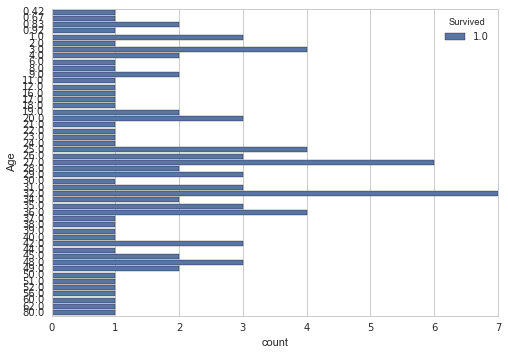

In [41]:
g = sns.countplot(y="Age", hue="Survived", data=df[(df['Sex'] == 'male') & (df['Survived'] == 1)])

In [46]:
print("< 10 : ", len(df[(df['Sex'] == 'male') & (df['Age'] < 10) & (df['Survived'] == 1)]))
print("< 20 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 10) & (df['Age'] < 20) & (df['Survived'] == 1)]))
print("< 30 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 20) & (df['Age'] < 30) & (df['Survived'] == 1)]))
print("< 40 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 30) & (df['Age'] < 40) & (df['Survived'] == 1)]))
print("< 50 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 40) & (df['Age'] < 50) & (df['Survived'] == 1)]))
print("< 60 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 50) & (df['Age'] < 60) & (df['Survived'] == 1)]))
print("< 70 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 60) & (df['Age'] < 70) & (df['Survived'] == 1)]))
print("< 80 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 70) & (df['Age'] < 80) & (df['Survived'] == 1)]))
print("> 80 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 80) & (df['Survived'] == 1)]))

('< 10 : ', 19)
('< 20 : ', 7)
('< 30 : ', 25)
('< 40 : ', 23)
('< 50 : ', 12)
('< 60 : ', 4)
('< 70 : ', 2)
('< 80 : ', 0)
('> 80 : ', 1)


In [47]:
print("< 10 : ", len(df[(df['Sex'] == 'male') & (df['Age'] < 10) & (df['Survived'] == 0)]))
print("< 20 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 10) & (df['Age'] < 20) & (df['Survived'] == 0)]))
print("< 30 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 20) & (df['Age'] < 30) & (df['Survived'] == 0)]))
print("< 40 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 30) & (df['Age'] < 40) & (df['Survived'] == 0)]))
print("< 50 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 40) & (df['Age'] < 50) & (df['Survived'] == 0)]))
print("< 60 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 50) & (df['Age'] < 60) & (df['Survived'] == 0)]))
print("< 70 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 60) & (df['Age'] < 70) & (df['Survived'] == 0)]))
print("< 80 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 70) & (df['Age'] < 80) & (df['Survived'] == 0)]))
print("> 80 : ", len(df[(df['Sex'] == 'male') & (df['Age'] >= 80) & (df['Survived'] == 0)]))

('< 10 : ', 13)
('< 20 : ', 50)
('< 30 : ', 123)
('< 40 : ', 84)
('< 50 : ', 45)
('< 60 : ', 26)
('< 70 : ', 13)
('< 80 : ', 6)
('> 80 : ', 0)


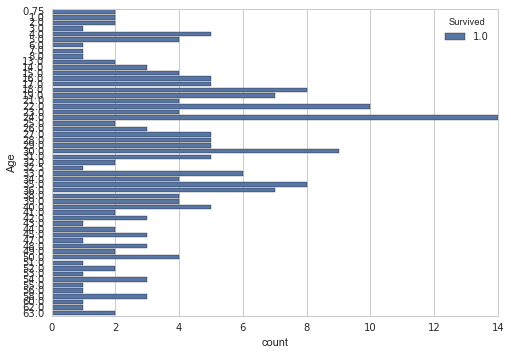

In [42]:
g = sns.countplot(y="Age", hue="Survived", data=df[(df['Sex'] == 'female') & (df['Survived'] == 1)])

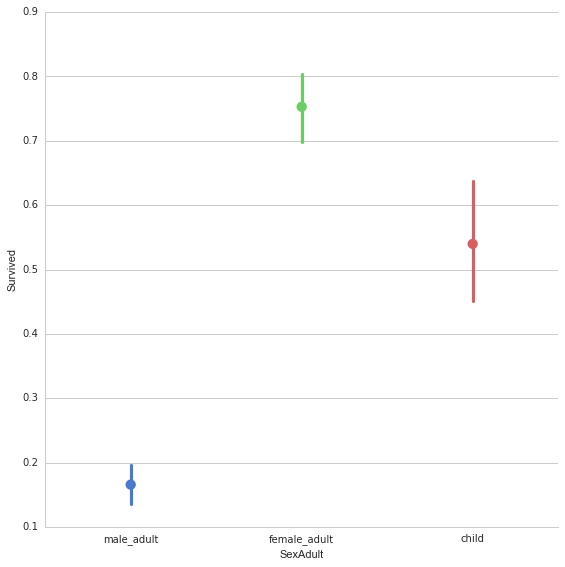

In [15]:
def get_sex_adult(row):
    age, sex = row
    if age < 18:
        return 'child'
    elif sex == 'female':
        return 'female_adult'
    else:
        return 'male_adult'

df['SexAdult'] = df[['Age', 'Sex']].apply(get_sex_adult, axis=1)
g = sns.factorplot(x="SexAdult", y="Survived", data=df, size=8, palette="muted")

if 'SexAdult' not in categorical_columns:
    categorical_columns.append('SexAdult')

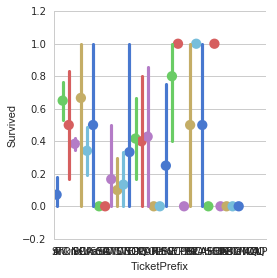

In [16]:
# https://www.kaggle.com/c/titanic/forums/t/11127/do-ticket-numbers-mean-anything
#print(df["Ticket"])
#print(df["Ticket"].value_counts())

def get_ticket_prefix(cabin):
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('[^\d]+', cabin)
    if cabin_search_result:
        return cabin_search_result.group(0).replace('/', '').replace('.', '')
    return 'unknown'

df['TicketPrefix'] = df['Ticket'].apply(get_ticket_prefix)
g = sns.factorplot(x="TicketPrefix", y="Survived", data=df, size=4, palette="muted")

if 'TicketPrefix' not in categorical_columns:
    categorical_columns.append('TicketPrefix')

In [17]:
df_ticket = pd.DataFrame(df['Ticket'].value_counts())
df_ticket.rename(columns={'Ticket':'TicketMembers'}, inplace=True)

df_ticket['Ticket_perishing_women'] = df.Ticket[(df.SexAdult == 'female_adult')
                                               & (df.Survived == 0.0)
                                               & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_ticket['Ticket_perishing_women'] = df_ticket['Ticket_perishing_women'].fillna(0)
if 'Ticket_perishing_women' not in numerical_columns:
    numerical_columns.append('Ticket_perishing_women')
df_ticket['TicketGroup_include_perishing_women'] = df_ticket['Ticket_perishing_women'] > 0
df_ticket['TicketGroup_include_perishing_women'] = df_ticket['TicketGroup_include_perishing_women'].astype(int)
if 'TicketGroup_include_perishing_women' not in numerical_columns:
    numerical_columns.append('TicketGroup_include_perishing_women')

df_ticket['Ticket_surviving_men'] = df.Ticket[(df.SexAdult == 'male_adult')
                                              & (df.Survived == 1.0)
                                              & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_ticket['Ticket_surviving_men'] = df_ticket['Ticket_surviving_men'].fillna(0)
if 'Ticket_surviving_men' not in numerical_columns:
    numerical_columns.append('Ticket_surviving_men')
df_ticket['TicketGroup_include_surviving_men'] = df_ticket['Ticket_surviving_men'] > 0
df_ticket['TicketGroup_include_surviving_men'] = df_ticket['TicketGroup_include_surviving_men'].astype(int)
if 'TicketGroup_include_surviving_men' not in numerical_columns:
    numerical_columns.append('TicketGroup_include_surviving_men')

df_ticket["TicketId"] = pd.Categorical.from_array(df_ticket.index).codes
df_ticket["TicketId"][df_ticket['TicketMembers'] < 3] = -1
if 'TicketId' not in numerical_columns:
    numerical_columns.append('TicketId')
df_ticket["TicketMembers"] = pd.cut(df_ticket['TicketMembers'], bins=[0,1,4,20], labels=[0,1,2])
if 'TicketMembers' not in numerical_columns:
    numerical_columns.append('TicketMembers')
df = pd.merge(df, df_ticket, left_on="Ticket", right_index=True, how='left', sort=False)

c:\develop\python27\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


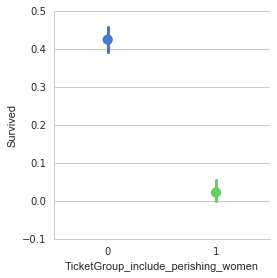

In [18]:
g = sns.factorplot(x="TicketGroup_include_perishing_women", y="Survived", data=df, size=4, palette="muted")

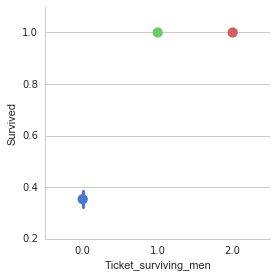

In [19]:
g = sns.factorplot(x="Ticket_surviving_men", y="Survived", data=df, size=4, palette="muted")

In [20]:
# surname
df['surname'] = df['Name'].apply(lambda x: x.split(',')[0].lower())
df_surname = pd.DataFrame(df['surname'].value_counts())
df_surname.rename(columns={'surname':'SurnameMembers'}, inplace=True)

df_surname['Surname_perishing_women'] = df.surname[(df.SexAdult == 'female_adult')
                                               & (df.Survived == 0.0)
                                               & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_surname['Surname_perishing_women'] = df_surname['Surname_perishing_women'].fillna(0)
df_surname['SurnameGroup_include_perishing_women'] = df_surname['Surname_perishing_women'] > 0
df_surname['SurnameGroup_include_perishing_women'] = df_surname['SurnameGroup_include_perishing_women'].astype(int)

df_surname['Surname_surviving_men'] = df.surname[(df.SexAdult == 'male_adult')
                                              & (df.Survived == 1.0)
                                              & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_surname['Surname_surviving_men'] = df_surname['Surname_surviving_men'].fillna(0)
df_surname['SurnameGroup_include_surviving_men'] = df_surname['Surname_surviving_men'] > 0
df_surname['SurnameGroup_include_surviving_men'] = df_surname['SurnameGroup_include_surviving_men'].astype(int)

df_surname["SurnameId"] = pd.Categorical.from_array(df_surname.index).codes
df_surname["SurnameId"][df_surname['SurnameMembers'] < 3] = -1
df_surname["SurnameMembers"] = pd.cut(df_surname['SurnameMembers'], bins=[0,1,4,20], labels=[0,1,2])
df = pd.merge(df, df_surname, left_on="surname", right_index=True, how='left', sort=False)


if 'Surname_perishing_women' not in numerical_columns:
    numerical_columns.append('Surname_perishing_women')
if 'SurnameGroup_include_perishing_women' not in numerical_columns:
    numerical_columns.append('SurnameGroup_include_perishing_women')
if 'Surname_surviving_men' not in numerical_columns:
    numerical_columns.append('Surname_surviving_men')
if 'SurnameGroup_include_surviving_men' not in numerical_columns:
    numerical_columns.append('SurnameGroup_include_surviving_men')
if 'SurnameId' not in numerical_columns:
    numerical_columns.append('SurnameId')
if 'SurnameMembers' not in numerical_columns:
    numerical_columns.append('SurnameMembers')

c:\develop\python27\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


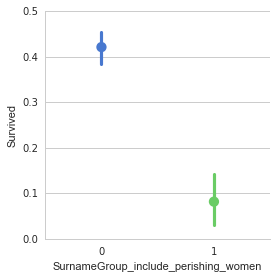

In [21]:
g = sns.factorplot(x="SurnameGroup_include_perishing_women", y="Survived", data=df, size=4, palette="muted")

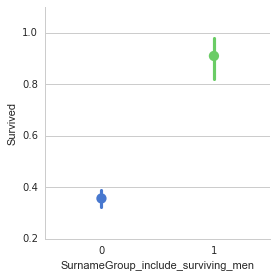

In [22]:
g = sns.factorplot(x="SurnameGroup_include_surviving_men", y="Survived", data=df, size=4, palette="muted")

In [23]:
for col in categorical_columns:
    df = category_to_numeric(df, col)

In [24]:
# age prediction
from sklearn.ensemble import ExtraTreesRegressor

age_prediction_features = ['Fare', 'Parch', 'Pclass', 'SibSp', 'Sex_female', 'Sex_male', 'FamilySize',
                           'NameLength', 'TicketMembers', 'TicketId', 
                           'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Embarked_unknown', 
                           'Name_title_Mr', 'Name_title_Mrs', 'Name_title_Miss', 'Name_title_Master', 
                           'Name_title_Don', 'Name_title_Rev', 'Name_title_Dr', 'Name_title_Mme', 'Name_title_Ms', 
                           'Name_title_Major', 'Name_title_Lady', 'Name_title_Sir', 'Name_title_Mlle', 'Name_title_Col', 
                           'Name_title_Capt', 'Name_title_Countess', 'Name_title_Jonkheer', 
                           'CabinLocation_unknown', 'CabinLocation_starboard', 'CabinLocation_port', 'CabinDeck_unknown', 
                           'CabinDeck_C', 'CabinDeck_E', 'CabinDeck_G', 'CabinDeck_D', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_F', 'CabinDeck_T']
age_prediction_tree_regressor = ExtraTreesRegressor(n_estimators=200)
age_X_train = df[age_prediction_features][df['Age'].notnull()]
age_Y_train = df['Age'][df['Age'].notnull()]
age_prediction_tree_regressor.fit(age_X_train, np.ravel(age_Y_train))

df['Age_pred'] = age_prediction_tree_regressor.predict(df[age_prediction_features])
if 'Age_pred' not in numerical_columns:
    numerical_columns.append('Age_pred')

In [25]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_classif

train = df[0:891].fillna(0).copy()
target = train["Survived"].values

selector = SelectKBest(f_classif, k=len(numerical_columns))
selector.fit(train[numerical_columns], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],numerical_columns[indices[f]]))

Features importance :
nan TicketPrefix_A 
nan TicketPrefix_AQ
nan TicketPrefix_STONOQ 
nan Name_title_Dona
nan TicketPrefix_LP 
70.61 Name_title_Mr
68.85 Sex_male
68.85 Sex_female
64.90 SexAdult_male_adult
53.23 SexAdult_female_adult
24.68 Name_title_Mrs
24.60 Pclass
23.69 NameLength
22.94 Name_title_Miss
21.51 CabinDeck_unknown
21.46 CabinLocation_unknown
17.23 CabinCount
17.00 TicketGroup_include_surviving_men
16.30 Ticket_surviving_men
14.21 Fare
13.54 TicketGroup_include_perishing_women
13.22 CabinLocation_starboard
13.04 SurnameGroup_include_surviving_men
12.71 Surname_surviving_men
10.83 Ticket_perishing_women
10.36 SurnameGroup_include_perishing_women
9.04 Surname_perishing_women
6.84 CabinDeck_B
6.73 CabinLocation_port
6.36 Embarked_C
5.52 Embarked_S
5.27 TicketMembers
5.21 CabinDeck_D
4.98 TicketPrefix_PC 
4.88 CabinDeck_E
3.59 SexAdult_child
3.27 TicketPrefix_A
3.22 CabinDeck_C
1.96 Name_title_Master
1.83 Parch
1.35 TicketPrefix_SOTONOQ 
1.31 Age_pred
1.28 Name_title_Rev
1.26

c:\develop\python27\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [43 90 91 92 93] are constant.
  UserWarning)


In [26]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, train[numerical_columns], target, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(train[numerical_columns], target)
score = random_forest.score(train[numerical_columns], target)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(numerical_columns)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, numerical_columns[indices[f]]))

Accuracy: 89.562 (+/- 1.20) [Random Forest Cross Validation]
Accuracy: 96.409             [Random Forest full test]
1. feature 5 (6.578495) Fare
2. feature 7 (6.572739) NameLength
3. feature 95 (6.011925) Age_pred
4. feature 21 (5.596466) Sex_male
5. feature 22 (5.438139) Sex_female
6. feature 27 (5.175430) Name_title_Mr
7. feature 57 (4.516515) SexAdult_male_adult
8. feature 2 (4.430184) Age
9. feature 9 (3.918993) Ticket_perishing_women
10. feature 10 (3.882417) TicketGroup_include_perishing_women
11. feature 15 (3.782196) Surname_perishing_women
12. feature 58 (3.695500) SexAdult_female_adult
13. feature 16 (3.670579) SurnameGroup_include_perishing_women
14. feature 1 (3.345550) Pclass
15. feature 11 (2.448583) Ticket_surviving_men
16. feature 12 (2.331743) TicketGroup_include_surviving_men
17. feature 14 (2.272133) TicketMembers
18. feature 6 (1.922403) FamilySize
19. feature 29 (1.887787) Name_title_Miss
20. feature 28 (1.860728) Name_title_Mrs
21. feature 20 (1.445329) SurnameMem

In [27]:
# select specidic features
features = ['Sex_female','Sex_male','Age_pred','SexAdult_male_adult','SexAdult_female_adult', 'SexAdult_child',
            'Pclass', 'TicketId','NameLength', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'SurnameMembers', 'TicketMembers',
            'TicketGroup_include_perishing_women','TicketGroup_include_surviving_men',
            'SurnameGroup_include_perishing_women','SurnameGroup_include_surviving_men',
            'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Embarked_unknown', 
            'Name_title_Mr', 'Name_title_Mrs', 'Name_title_Miss', 'Name_title_Master', 
            'Name_title_Don', 'Name_title_Rev', 'Name_title_Dr', 'Name_title_Mme', 'Name_title_Ms', 
            'Name_title_Major', 'Name_title_Lady', 'Name_title_Sir', 'Name_title_Mlle', 'Name_title_Col', 
            'Name_title_Capt', 'Name_title_Countess', 'Name_title_Jonkheer', 
            'CabinLocation_unknown', 'CabinLocation_starboard', 'CabinLocation_port', 'CabinDeck_unknown', 
            'CabinDeck_C', 'CabinDeck_E', 'CabinDeck_G', 'CabinDeck_D', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_F', 'CabinDeck_T']

random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, train[features], target, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(train[features], target)
score = random_forest.score(train[features], target)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, features[indices[f]]))

Accuracy: 89.787 (+/- 0.84) [Random Forest Cross Validation]
Accuracy: 96.184             [Random Forest full test]
1. feature 12 (8.766979) Fare
2. feature 9 (8.439142) NameLength
3. feature 3 (8.184386) Age_pred
4. feature 16 (7.382709) TicketGroup_include_perishing_women
5. feature 18 (6.627499) SurnameGroup_include_perishing_women
6. feature 2 (6.308788) Sex_male
7. feature 24 (5.486266) Name_title_Mr
8. feature 1 (5.059514) Sex_female
9. feature 7 (5.019466) Pclass
10. feature 4 (4.309755) SexAdult_male_adult
11. feature 17 (4.303996) TicketGroup_include_surviving_men
12. feature 5 (3.575601) SexAdult_female_adult
13. feature 15 (2.741983) TicketMembers
14. feature 13 (2.459715) FamilySize
15. feature 19 (2.360931) SurnameGroup_include_surviving_men
16. feature 14 (2.066773) SurnameMembers
17. feature 25 (1.631994) Name_title_Mrs
18. feature 26 (1.625980) Name_title_Miss
19. feature 44 (1.558712) CabinDeck_unknown
20. feature 8 (1.427579) TicketId
21. feature 41 (1.385426) CabinLo

In [28]:
# analyze failed.
features = ['Sex_female','Sex_male','Age_pred','SexAdult_male_adult','SexAdult_female_adult', 'SexAdult_child',
            'Pclass', 'TicketId','NameLength', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'SurnameMembers', 'TicketMembers',
            'TicketGroup_include_perishing_women','TicketGroup_include_surviving_men',
            'SurnameGroup_include_perishing_women','SurnameGroup_include_surviving_men',
            'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Embarked_unknown', 
            'Name_title_Mr', 'Name_title_Mrs', 'Name_title_Miss', 'Name_title_Master', 
            'Name_title_Don', 'Name_title_Rev', 'Name_title_Dr', 'Name_title_Mme', 'Name_title_Ms', 
            'Name_title_Major', 'Name_title_Lady', 'Name_title_Sir', 'Name_title_Mlle', 'Name_title_Col', 
            'Name_title_Capt', 'Name_title_Countess', 'Name_title_Jonkheer', 
            'CabinLocation_unknown', 'CabinLocation_starboard', 'CabinLocation_port', 'CabinDeck_unknown', 
            'CabinDeck_C', 'CabinDeck_E', 'CabinDeck_G', 'CabinDeck_D', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_F', 'CabinDeck_T']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(train, target, test_size=0.2, random_state=42)
random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(X_train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, X_train[features], y_train, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(X_train[features], y_train)
score = random_forest.score(X_test[features], y_test)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))
pred_test = random_forest.predict(X_test[features])

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, features[indices[f]]))

Accuracy: 88.907 (+/- 1.53) [Random Forest Cross Validation]
Accuracy: 92.179             [Random Forest full test]
1. feature 12 (8.603726) Fare
2. feature 3 (8.073160) Age_pred
3. feature 9 (7.814268) NameLength
4. feature 16 (6.691682) TicketGroup_include_perishing_women
5. feature 18 (6.346775) SurnameGroup_include_perishing_women
6. feature 2 (6.220492) Sex_male
7. feature 7 (5.495419) Pclass
8. feature 24 (5.348071) Name_title_Mr
9. feature 1 (4.997784) Sex_female
10. feature 4 (4.702065) SexAdult_male_adult
11. feature 5 (4.197552) SexAdult_female_adult
12. feature 17 (4.026796) TicketGroup_include_surviving_men
13. feature 15 (2.870908) TicketMembers
14. feature 19 (2.601923) SurnameGroup_include_surviving_men
15. feature 13 (2.484205) FamilySize
16. feature 14 (2.175967) SurnameMembers
17. feature 25 (2.144181) Name_title_Mrs
18. feature 8 (1.563971) TicketId
19. feature 26 (1.513487) Name_title_Miss
20. feature 41 (1.324439) CabinLocation_unknown
21. feature 10 (1.298217) Sib

In [29]:
pd.set_option("display.max_columns",101)
X_test_reseted = X_test.reset_index()
X_test_reseted['Survived'] = y_test
X_test_reseted['Prediction'] = pred_test
X_test_reseted['pred_result'] = pred_test == y_test
#print(X_test_reseted[X_test_reseted['pred_result'] == False])
print(X_test_reseted[(X_test_reseted['pred_result'] == False) & (X_test_reseted['Sex'] == 'male') 
                     & (X_test_reseted['Pclass'] == 1) 
                     & (20 <= X_test_reseted['Age_pred']) & (X_test_reseted['Age_pred'] <= 45) 
                     & (X_test_reseted['Fare'] <= 35) & (X_test_reseted['Fare'] >= 10)
                     & (X_test_reseted['TicketPrefix_unknown'] == 1)
                     & (X_test_reseted['TicketMembers'] == 0)
                     & (X_test_reseted['CabinCount'] == 0)
                    ])

     index   Age Cabin Embarked   Fare  \
21     447  34.0     0        S  26.55   
125    604  35.0     0        C  26.55   
161    507   0.0     0        S  26.55   

                                              Name  Parch  PassengerId  \
21                     Seward, Mr. Frederic Kimber      0          448   
125                Homer, Mr. Harry ("Mr E Haven")      0          605   
161  Bradley, Mr. George ("George Arthur Brayton")      0          508   

     Pclass   Sex  SibSp  Survived  Ticket Name_title  FamilySize  NameLength  \
21        1  male      0       1.0  113794         Mr           0          27   
125       1  male      0       1.0  111426         Mr           0          31   
161       1  male      0       1.0  111427         Mr           0          45   

    CabinLocation CabinDeck  CabinCount    SexAdult TicketPrefix  \
21        unknown   unknown           0  male_adult      unknown   
125       unknown   unknown           0  male_adult      unknown   
161  

In [30]:
print(df[(df['Survived'] == 0) & (df['Sex'] == 'male') 
         & (df['Pclass'] == 1) 
         & (20 <= df['Age_pred']) & (df['Age_pred'] <= 45) 
         & (df['Fare'] <= 35) & (df['Fare'] >= 10) 
         & (df['TicketPrefix_unknown'] == 1)
         & (df['TicketMembers'] == 0)
         & (df['CabinCount'] == 0)])

Empty DataFrame
Columns: [Age, Cabin, Embarked, Fare, Name, Parch, PassengerId, Pclass, Sex, SibSp, Survived, Ticket, Name_title, FamilySize, NameLength, CabinLocation, CabinDeck, CabinCount, SexAdult, TicketPrefix, TicketMembers, Ticket_perishing_women, TicketGroup_include_perishing_women, Ticket_surviving_men, TicketGroup_include_surviving_men, TicketId, surname, SurnameMembers, Surname_perishing_women, SurnameGroup_include_perishing_women, Surname_surviving_men, SurnameGroup_include_surviving_men, SurnameId, Sex_female, Sex_male, Embarked_C, Embarked_Q, Embarked_S, Embarked_unknown, Name_title_Capt, Name_title_Col, Name_title_Countess, Name_title_Don, Name_title_Dona, Name_title_Dr, Name_title_Jonkheer, Name_title_Lady, Name_title_Major, Name_title_Master, Name_title_Miss, Name_title_Mlle, Name_title_Mme, Name_title_Mr, Name_title_Mrs, Name_title_Ms, Name_title_Rev, Name_title_Sir, CabinLocation_port, CabinLocation_starboard, CabinLocation_unknown, CabinDeck_A, CabinDeck_B, CabinDec

In [31]:
test = df[891:].copy()
random_forest.fit(train[features], target)
predictions = random_forest.predict(test[features])

In [32]:
PassengerId = np.array(test["PassengerId"]).astype(int)
submit_df = pd.DataFrame(predictions, PassengerId, columns = ['Survived']).astype(int)
submit_df.to_csv('titanic.csv', index_label=['PassengerId'])